# Problématique

<h3> Prédire le mot dans l'image </h3>

- Création de dataset Tensorflow pour faire des traitements par lots et pouvoir utiliser toutes les images de la base pour le modele
- Modèle Deep learning : RNN
- Évaluation du modèle : ?


# Import

In [3]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import re
from os.path import exists
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import string


import letter_detection_utils as ld_util
import preprocessing as pp
import ressources as rss
import modele as mdl
import rendering as rd
import metric_orthograph as mo


In [41]:
# Pour recharger les libs pendant les devs
from importlib import reload 
reload(ld_util)
reload(pp)
reload(rss)
reload(mdl)
reload(rd)
reload(mo)

<module 'metric_orthograph' from 'd:\\VSCode-Folder\\OCRpyMAN\\notebooks\\metric_orthograph.py'>

# Chargement du dataframe

In [4]:
# initialisation des variables globales
rss.init()

In [5]:
# Chargement avec tensorflow et dataset par batch

dataset_train, dataset_test, X_test, y_test = ld_util.get_dataset(augmented=True)

Instructions for updating:
delimiter is deprecated, please use sep instead.


2023-02-03 10:42:34.198 WARNING tensorflow: From c:\Users\Oj\miniconda3\envs\GPU\lib\site-packages\tensorflow\python\util\dispatch.py:1176: calling string_split (from tensorflow.python.ops.ragged.ragged_string_ops) with delimiter is deprecated and will be removed in a future version.
Instructions for updating:
delimiter is deprecated, please use sep instead.


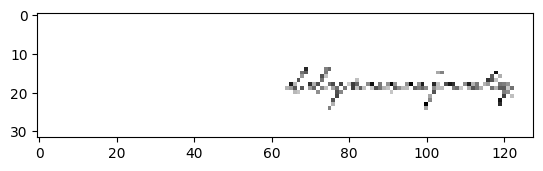

In [ ]:
### TEST - TODELETE ###
# Visualisation du contenu du dataset créé au-dessus


from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
        
x, y = next(iter(dataset_train))
x[0].shape

tmp = x[10]
# tmp = tf.squeeze(tmp, axis=2)
# tmp = np.swapaxes(tmp, 0, 1)
# tmp = tmp.reshape(128,32)
plt.imshow(tmp , cmap='gray');  # .reshape(rss.img_size)




### Affichage des données preprocessées

In [ ]:
batch_id=0
iterator = iter(dataset_train)

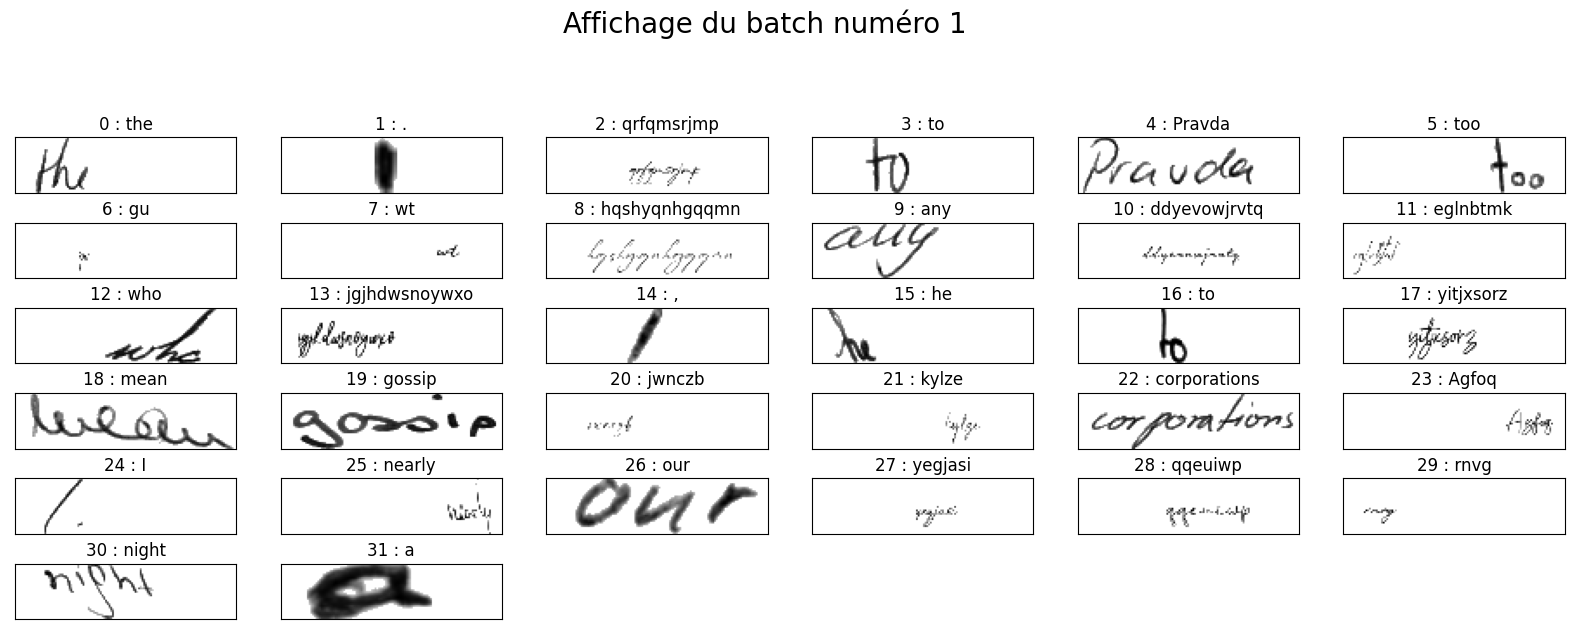

In [ ]:
x,y = iterator.get_next()
batch_id +=1
rd.show_iterator_batch(x,y,batch_id, 32)

# Model RNN

### Création Modèle

In [ ]:
model = mdl.create_modele()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 128, 32)       832       
                                                                 
 batch_normalization (BatchN  (None, 32, 128, 32)      128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 128, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 64, 64)       2

In [ ]:

# Pour stopper l'apprentissage si la val_loss n'évolue plus
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    restore_best_weights=True
)

# Backup temporaire du modele à chaque epoch. Pour restaurer, utiliser : model.load_weights('tmp_model')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tmp_model', 
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch'
)

# ajouter un ReduceLROnPlateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    mode='min',
    min_delta=0.1,
    min_lr=0.00001
)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=mdl.CTCLoss(), optimizer=optimizer)
history = model.fit(
    dataset_train,
    validation_data=dataset_test,
    callbacks=[
        early_stop_callback,
        checkpoint_callback,
        reduce_lr
    ],
    epochs=20
)

Epoch 1/2
4213/4213 [==============================] - ETA: 0s - loss: 9.5491

2023-02-02 17:15:07.306 WARNING absl: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 9). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: tmp_model\assets


2023-02-02 17:15:10.973 INFO    tensorflow: Assets written to: tmp_model\assets


4213/4213 [==============================] - 358s 83ms/step - loss: 9.5491 - val_loss: 13.1173 - lr: 0.0010
Epoch 2/2
4213/4213 [==============================] - 181s 43ms/step - loss: 5.7875 - val_loss: 21.2692 - lr: 0.0010


In [43]:
# Sauvegarde et/ou rechargement de l'history dans un pickle et du modele  : décommenter la partie voulue
### ATTENTION ### un historique créé sur une autre machine ne peut pas se charger... il faut donc sauver son contenu (.history)

#Sauvegarde historique
# with open('../pickle/tj_ctc_augmented_20epochs_LR-plateau_2.pickle', 'wb') as file_pi:
#     pickle.dump(history.history, file_pi)

#Rechargement historique
# with open('../pickle/tj_ctc_model_10_history.pickle', "rb") as file_pi:
#     history = pickle.load(file_pi)


# Sauvegarde/Chargement du modele
# model.save('../pickle/tj_ctc_augmented_20epochs_LR-plateau_2')
# model = tf.keras.models.load_model("../pickle/tj_ctc_augmented_20epochs_LR-plateau", custom_objects={"CTCLoss": mdl.CTCLoss})

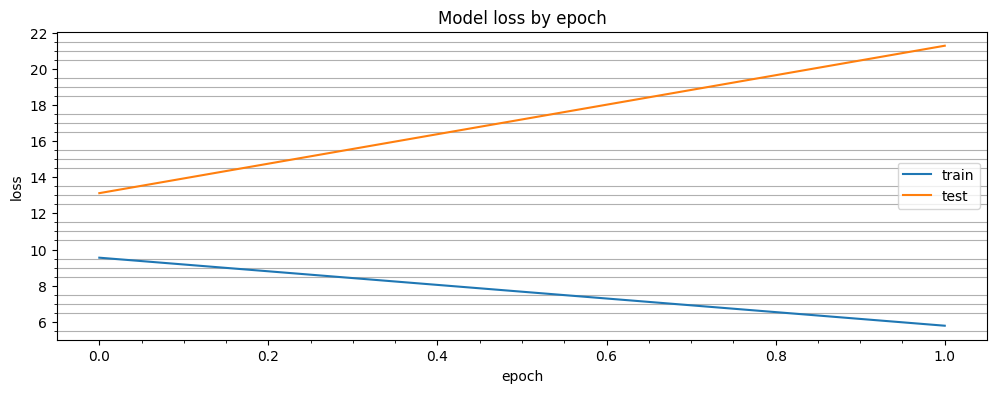

In [ ]:
# Affichage des courbes de perte    

mdl.show_loss(history.history)

In [ ]:
print(history.history)

{'loss': [9.5491304397583, 5.78749942779541], 'val_loss': [13.117321014404297, 21.26920509338379], 'lr': [0.001, 0.001]}


In [44]:
# Apperçu du résultat avec quelques prédictions

y_pred = model.predict(dataset_test)
predicted_transcriptions = ld_util.greedy_decoder(y_pred, rss.charList)

mdl.evaluate_prediction(y_test, predicted_transcriptions)



297/297 [==============================] - 13s 39ms/step
Notre modèle a une précision par mot de 0.9345753315879767  pour  9490  mots.


In [45]:
# OPTIMISATION AVEC CORRECTION ORTHOGRAPHIQUE

# le premier correcteur utilisé par david fait parfois des corrections étranges
# fixed_prediction = mo.ortho_corrector_liste(predicted_transcriptions, 1)

# test avec la librairie "autocorrect"
fixed_prediction = mo.autocorrect_liste(predicted_transcriptions)


In [46]:
mdl.evaluate_prediction(y_test, fixed_prediction)



Notre modèle a une précision par mot de 0.9384984328398449  pour  9490  mots.


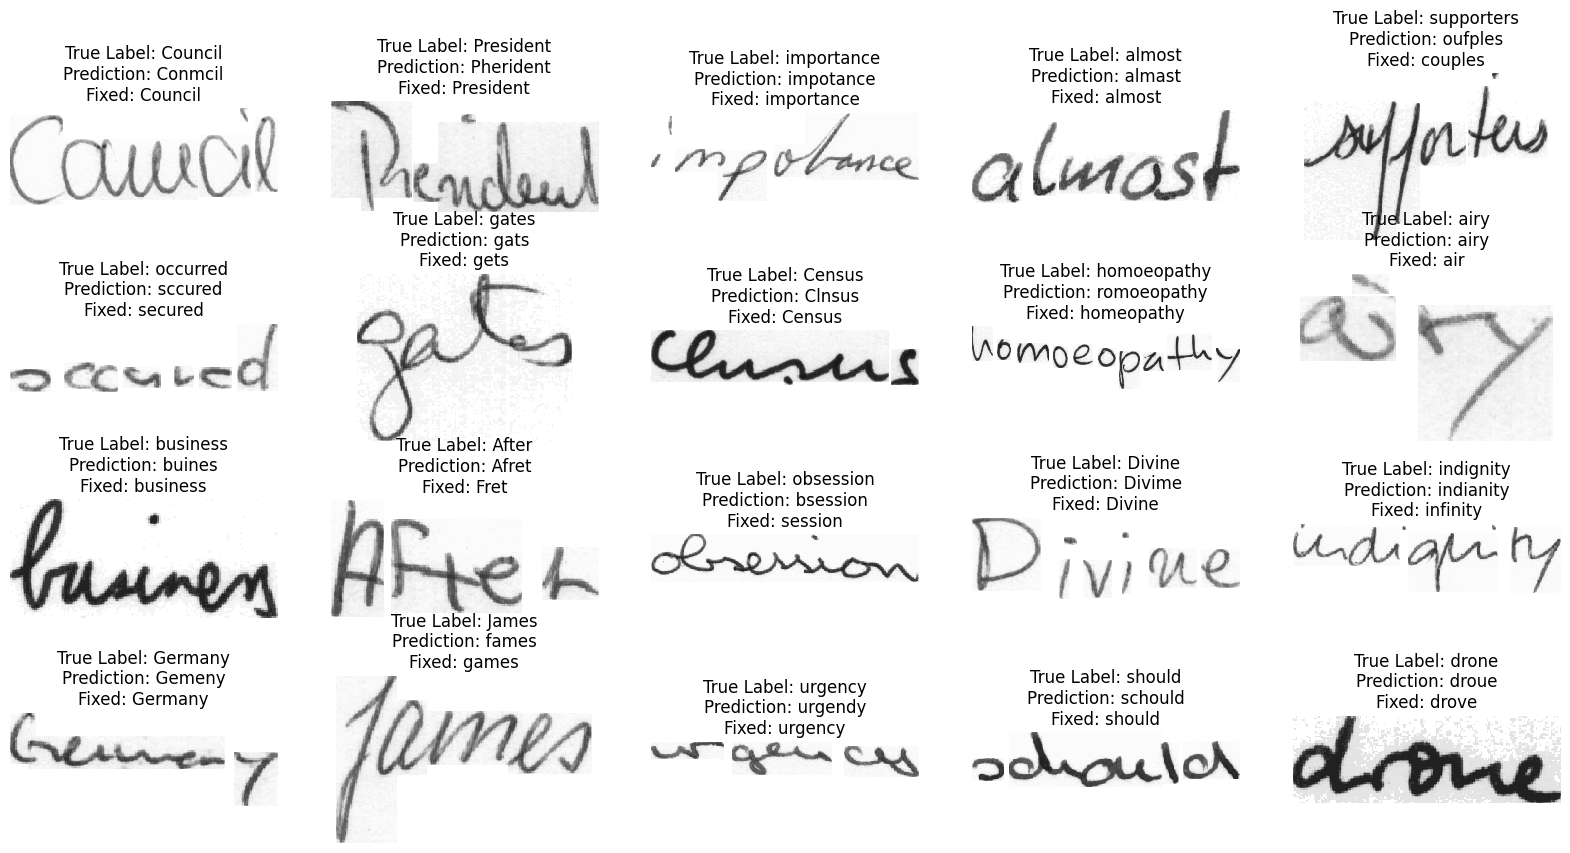

In [47]:
# Appercu des mots mal prédits
rd.show_words_predictions_errors(X_test, y_test, y_pred, predicted_transcriptions, fixed_prediction)

# => certains mots sont coupés, ou contiennent une faute d'orthographe/échange de lettres
    